In [ ]:
import json
from utils.bow import Bow
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.cluster import AffinityPropagation
from collections import defaultdict
import seaborn as sns
import numpy as np
from utils.word2vec import Word2WordPrediction, Word2VecModel, WordEmbeddings

plt.style.use('seaborn-v0_8-dark-palette')

In [5]:
with open('data/weather.json', 'r') as file_in:
    data = json.load(file_in)
weather = data['weather']
for doc in weather:
    print(" | ".join(doc))

mountains | snow | ice | peak | woods | cold
beach | sand | sea | wave | sun | hot
desert | dune | cactus | sand | sun | arid
forest | tree | leaf | animal | rain | humidity
river | water | fish | spring | current | bank
sky | cloud | wind | rain | thunder | rainbow


In [7]:
bow = Bow(corpus=weather)
data_loader, inputs, outputs = bow.one_hot_skip_gram_dataloader(window=2, batch=2)

In [9]:
# Example input
pd.DataFrame(inputs, columns=bow.vocabulary).iloc[0].head()

mountains    1.0
snow         0.0
ice          0.0
peak         0.0
woods        0.0
Name: 0, dtype: float32

In [10]:
# Example output (notice that mountains - the input - isn't in here)
pd.DataFrame(outputs, columns=bow.vocabulary).iloc[0].head()

mountains    0.0
snow         1.0
ice          1.0
peak         0.0
woods        0.0
Name: 0, dtype: float32

In [13]:
w2w = Word2WordPrediction(input_dim=bow.size, hidden_dim=4)
epochs = 150
learning_rate = 0.01
history = w2w.train(
    data_loader=data_loader,
    epochs=epochs,
    learning_rate=learning_rate
)
print(history[0], history[-1]) # History of errors

100%|██████████| 150/150 [00:05<00:00, 28.85it/s]

10.489047156439888 9.71256399154663


In [14]:
# The main way of using this is to only consider the Embeddings

# However, we can also use it to predict words
model = WordEmbeddings(words=bow, model=w2w)
model['desert'] # Embedding of 'desert'

array([ 2.011945 ,  2.14331  , -1.9545498,  2.1225908], dtype=float32)

In [15]:
query = 'snow'
next_word = model.predict(query, topk=10)
next_word

peak         0.999309
ice          0.000417
snow         0.000121
woods        0.000096
cloud        0.000012
mountains    0.000010
cold         0.000007
forest       0.000003
animal       0.000003
humidity     0.000002
dtype: float32

In [17]:
start = "desert"
text = [start]
for i in range(6):
    p = model.predict(start)
    # Sample one from the distribution
    next_word = np.random.choice(p.index.values, p=p.values / p.values.sum())
    text.append(next_word)
    start = next_word

print(" ".join(text))

desert dune sand dune sand sun sand


### Similarity with Word Embeddings

Notice that similarity doesn't necessarily match the idea of being similar things.
Similar words are those with a similar content.

In [24]:
# Let's use the Embeddings now

# We can use them for Similarity

search = 'desert'
model[search]

array([ 2.011945 ,  2.14331  , -1.9545498,  2.1225908], dtype=float32)

In [25]:
model.most_similar(search, topk=10)

desert    1.000000
sand      0.762203
rain      0.399906
sky       0.372315
tree      0.296826
forest    0.253525
hot       0.178326
sun       0.147142
sea       0.143161
ice       0.080562
Name: desert, dtype: float32

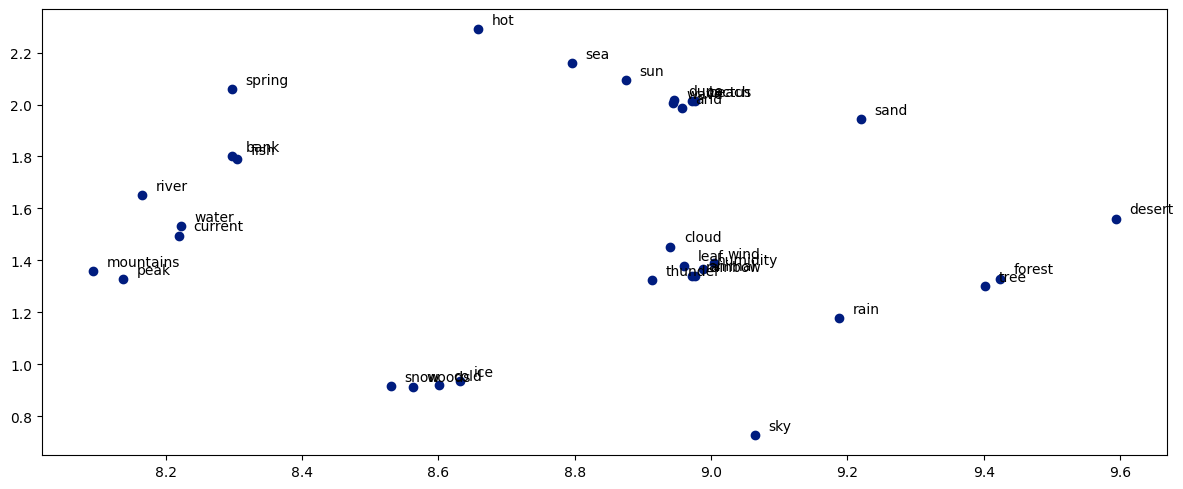

In [23]:
tsne = TSNE(n_components=2)
vectors = model.vectors(bow.vocabulary)
v2d = tsne.fit_transform(vectors)

selected_words = bow.vocabulary
indexes = [bow.word2idx[w] for w in selected_words]
selected2d = v2d[indexes]

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(selected2d[:,0], selected2d[:, 1])
for i, w in enumerate(selected_words):
    ax.text(selected2d[i][0] + .02, selected2d[i][1] + .02, w)
plt.tight_layout()
plt.show()

Cluster 4: mountains, peak, river, water, fish, spring, current, bank
Cluster 0: snow, ice, woods, cold, sky
Cluster 1: beach, sand, sea, wave, sun, hot, dune, cactus, arid
Cluster 2: desert, forest, tree
Cluster 3: leaf, animal, rain, humidity, cloud, wind, thunder, rainbow


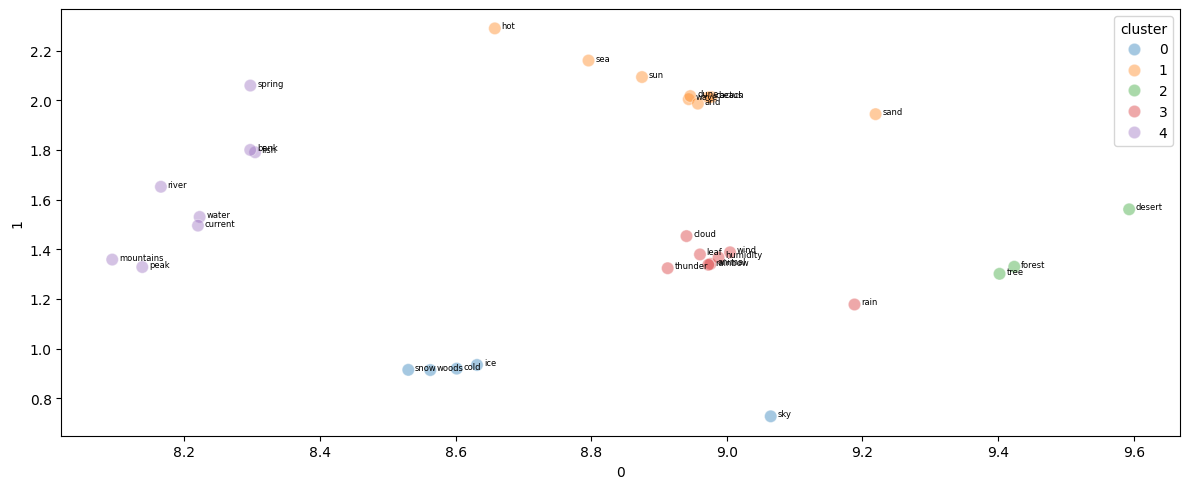

In [28]:
# Clustering could be used for building ontologies (or graphs and then community detection)

ap = AffinityPropagation() # Also finds the number of clusters
assignments = ap.fit_predict(selected2d)
clusters = defaultdict(list)
for i, cluster in enumerate(assignments):
    clusters[cluster].append(selected_words[i])

dfsample = pd.DataFrame(selected2d)
dfsample['word'] = selected_words
dfsample['cluster'] = assignments

# Each cluster is kind-of a context
for cluster, words in clusters.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

fig, ax = plt.subplots(figsize=(12, 5))
scatter = sns.scatterplot(
    data=dfsample,
    x=0,
    y=1,
    hue="cluster",
    s=80,
    palette="tab10",
    legend="full",
    ax=ax,
    alpha=0.4
)
for i in range(len(dfsample)):
    plt.text(dfsample[0][i] + 0.01, dfsample[1][i], dfsample.word[i], fontsize=6)
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

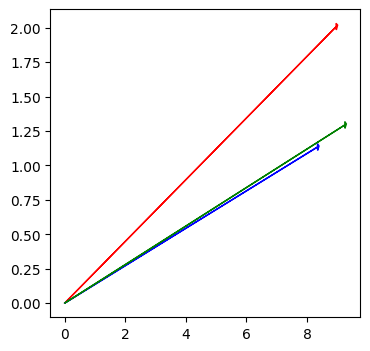

In [30]:
def pointer(group, vectors):
    g = vectors[[bow.word2idx[w] for w in group]]
    return g.mean(axis=0)

# Manually define groups
group1 = ['dune', 'beach', 'cactus', 'arid']
group2 = ['snow', 'peak', 'mountains', 'ice']
group3 = ['forest', 'tree', 'rain', 'humidity']
g1 = pointer(group1, v2d)
g2 = pointer(group2, v2d)
g3 = pointer(group3, v2d)

# Look at direction of the groups
fig, ax = plt.subplots(figsize=(4, 4))
ax.arrow(0, 0, g1[0], g1[1], head_width=0.05, head_length=0.05, fc='red', ec='red')
ax.arrow(0, 0, g2[0], g2[1], head_width=0.05, head_length=0.05, fc='blue', ec='blue')
ax.arrow(0, 0, g3[0], g3[1], head_width=0.05, head_length=0.05, fc='green', ec='green')
plt.tight_layout

### Compositionality of Word Embeddings

Word Embeddings have the property of Compositionality.
This means, that operations between words are possible.


In [32]:
# For instance, we can sum/subtract meaning of words

# We want to find the context of desert, without the meaning of dune
model.search(positive=['desert'], negative=['dune'])


desert       0.816915
ice          0.602255
woods        0.551866
cold         0.548359
sand         0.538404
snow         0.537488
sky          0.463786
rain         0.310469
peak         0.219577
mountains    0.130195
dtype: float32

In [34]:
# We can play with analogies

# For example: (king - man + woman) => queen
# Positive = [man, king], Negative = [woman] --> Find the missing negative
answer, a_vector = model.analogy('sea', 'wave', 'desert')
# The wave is for the sea what the sand is for the desert
answer

'sand'

In [36]:
# We can find common meanings between words

# We just compute the mean of the embeddings
model.common_meanings(['sea', 'wave', 'desert', 'sand'])

sand      0.894452
sea       0.795115
sun       0.743280
hot       0.713473
desert    0.700922
cactus    0.600917
wave      0.541060
beach     0.537736
dune      0.537507
arid      0.527818
dtype: float32

In [37]:
# We can spot 'odd' words in a list
model.spot_odd_one(words=['mountains', 'peak', 'snow', 'sand'])

sand         0.323529
snow         0.523786
mountains    0.891621
peak         0.921513
dtype: float32